# Projeto para a cadeira de Processamento de Linguagem Natural com deep learning

Professor: Luciano Barbosa

Grupo: Deyvison Camilo, Thiago Pereira

Análise de sentimentos

In [1]:
!pip install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234926 sha256=54e7f429a1b54d3015028b3b5b6cb9f08d94002047314c66dc2e216513d68c60
  Stored in directory: /root/.cache/pip/wheels/02/3d/88/51a592b9ad17e7899126563698b4e3961983ebe85747228ba6
Successfully built emoji


## Sobre o projeto

O presente projeto visa fazer um análise de sentimentos com 3 labels (negativo, neutro, positivo) dos comentários de usuários sobre as postagens da Receita Federal no Instagram. Foram coletados 12651 comentários, referentes a 372 postagens promovidas pelo Fisco.

Como os comentários não estavam rotulados foi necessário fazer manualmente uma parte (2025 comentários). No restante foi aplicado uma tentativa de rotulagem automática com um processo de clusterização, contudo a aboradagem não gerou bons resultados. Dessa forma, optou-se por prosseguir apenas com os dados rotulados manualmente. 

Foram utilizados 3 abordagens diferentes no projeto:
- SVM + BOW (foi o utilizado o tfidf para isso)
- SVM + embeddings
- BERT

Os experimentos, bem como o reporte dos resultados, seguem nas células abaixo.

Deve-se destacar que alguns parâmetros utilizados nos experimentos foram obtidos por meio de heurística.

## Preparando o ambiente

In [2]:
import random
from numpy import unique
from numpy import where
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import emoji
import nltk
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [3]:
pd.set_option('display.max_colwidth', None)

In [4]:
# Carregar drive
from google.colab import drive
drive.mount('/content/gdrive/')

MessageError: ignored

In [ ]:
%cd /content/gdrive/MyDrive/analise_de_sentimento_receita/

## Preparando a base da Receita Federal

In [6]:
df = pd.read_csv('comentarios_with_label_receita.csv')
df.head()

,title,comments,likes,label
0,"🌎🤝 A Receita Federal do Brasil 🇧🇷 e a Aduana Nacional da Bolívia 🇧🇴 se reuniram para ampliar as Áreas de Controle Integrado (ACI) de Corumbá e Puerto Suárez, simplificando os trâmites aduaneiros e trazendo mais eficiência para importação e exportação de mercadorias.🚛💨 Isso vai aumentar o volume de mercadorias no comércio exterior da região e melhorar o controle de circulação das mercadorias entre as aduanas.Saiba mais em nosso site, link na bio.... #ReceitaFederal #comércioexterior #trâmitesaduaneiros #ACI #Brasil #Bolívia #aduana 🌍💰💼","Parabéns, nota 0👏👏👏",4 curtidas,0
1,"🌎🤝 A Receita Federal do Brasil 🇧🇷 e a Aduana Nacional da Bolívia 🇧🇴 se reuniram para ampliar as Áreas de Controle Integrado (ACI) de Corumbá e Puerto Suárez, simplificando os trâmites aduaneiros e trazendo mais eficiência para importação e exportação de mercadorias.🚛💨 Isso vai aumentar o volume de mercadorias no comércio exterior da região e melhorar o controle de circulação das mercadorias entre as aduanas.Saiba mais em nosso site, link na bio.... #ReceitaFederal #comércioexterior #trâmitesaduaneiros #ACI #Brasil #Bolívia #aduana 🌍💰💼",👏👏👏❤️❤️❤️,1 curtida,2
2,"🌎🤝 A Receita Federal do Brasil 🇧🇷 e a Aduana Nacional da Bolívia 🇧🇴 se reuniram para ampliar as Áreas de Controle Integrado (ACI) de Corumbá e Puerto Suárez, simplificando os trâmites aduaneiros e trazendo mais eficiência para importação e exportação de mercadorias.🚛💨 Isso vai aumentar o volume de mercadorias no comércio exterior da região e melhorar o controle de circulação das mercadorias entre as aduanas.Saiba mais em nosso site, link na bio.... #ReceitaFederal #comércioexterior #trâmitesaduaneiros #ACI #Brasil #Bolívia #aduana 🌍💰💼",Eu conto ou vocês contam ?,5 curtidas,1
3,"🌎🤝 A Receita Federal do Brasil 🇧🇷 e a Aduana Nacional da Bolívia 🇧🇴 se reuniram para ampliar as Áreas de Controle Integrado (ACI) de Corumbá e Puerto Suárez, simplificando os trâmites aduaneiros e trazendo mais eficiência para importação e exportação de mercadorias.🚛💨 Isso vai aumentar o volume de mercadorias no comércio exterior da região e melhorar o controle de circulação das mercadorias entre as aduanas.Saiba mais em nosso site, link na bio.... #ReceitaFederal #comércioexterior #trâmitesaduaneiros #ACI #Brasil #Bolívia #aduana 🌍💰💼",Pai eterno! Tenha piedade 😮‍💨,Responder,1
4,"🌎🤝 A Receita Federal do Brasil 🇧🇷 e a Aduana Nacional da Bolívia 🇧🇴 se reuniram para ampliar as Áreas de Controle Integrado (ACI) de Corumbá e Puerto Suárez, simplificando os trâmites aduaneiros e trazendo mais eficiência para importação e exportação de mercadorias.🚛💨 Isso vai aumentar o volume de mercadorias no comércio exterior da região e melhorar o controle de circulação das mercadorias entre as aduanas.Saiba mais em nosso site, link na bio.... #ReceitaFederal #comércioexterior #trâmitesaduaneiros #ACI #Brasil #Bolívia #aduana 🌍💰💼",🤦🏻‍♂️🤦🏻‍♂️,1 curtida,0


In [7]:
print(f" Quantidade de postagens únicas: {df['title'].nunique()}\n",f"Quantidade de comentários de usuários: {df['comments'].count()}\n")

 Quantidade de postagens únicas: 372
 Quantidade de comentários de usuários: 12651



In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12674 entries, 0 to 12673
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     12674 non-null  object
 1   comments  12651 non-null  object
 2   likes     12674 non-null  object
 3   label     12674 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 396.2+ KB


In [9]:
# Selecionando apenas a quantidade com rotulagem manual dos labels
df = df.iloc[:2025]

In [10]:
# Eliminando os valores nulos
df = df.dropna()

In [11]:
# Quantidade de comentários por label. 2 é positivo, 1 é neutro e 0 é negativo
# O resultado foi 2022, pois houve a retirada dos comentários com valores nulos
df['label'].value_counts()
total_comments = df['label'].value_counts().sum()

In [12]:
# Substituição do emoji por meio da biblioteca emoji para o seu significado textual
df['comments_without_emoji'] = df['comments'].apply(lambda x: emoji.demojize(str(x), language='pt'))
df['label'] = df['label'].astype(int)

## Visualização textual por meio do wordcloud

In [13]:
# Carregar as stopwords em português para retirar da visualização
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('portuguese')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [14]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

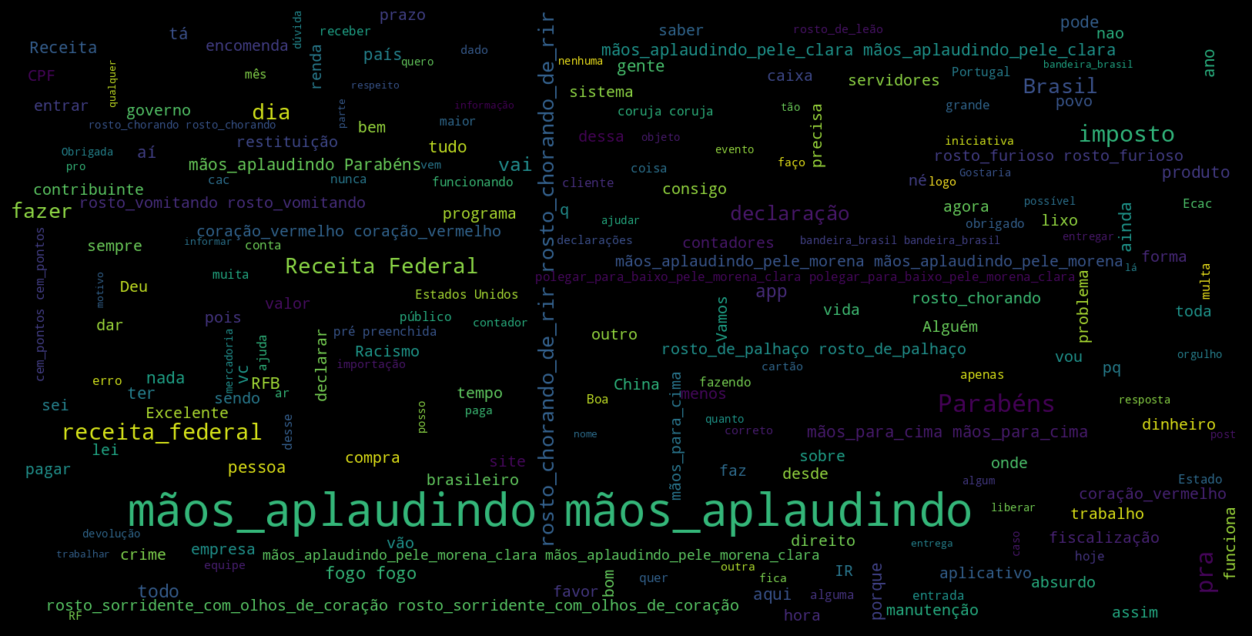

In [15]:
stopwords = set(stopwords)
textt = " ".join(review for review in df.comments_without_emoji)
wordcloud = WordCloud(width=1600, height=800,stopwords=stopwords).generate(textt)
plt.figure( figsize=(16,8), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('wordcloud_receita.png')
plt.show()

A visualização da figura gerada permite inferir que as principais palavras utilizadas são na verdade emojis, notadamento os positivos. Pelo seu  poder de comunicar um estado emocional de maneira célere, isso aparenta fazer total sentido para o uso em redes sociais.

## Utilizar a clusterização para tentar fazer um aumento da base rotulada (weak supervision)

In [16]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [17]:
# Função para promover uma limpeza na base para posterior clusterização
def preprocess_text(text: str, remove_stopwords: bool) -> str:
    text = re.sub("[^A-Za-z]+", " ", text)
    # remove stopwords
    if remove_stopwords:
        # 1. tokenize
        tokens = nltk.word_tokenize(text)
        # 2. check if stopword
        tokens = [w for w in tokens if not w.lower() in stopwords]
        # 3. join back together
        text = " ".join(tokens)
    # return text in lower case and stripped of whitespaces
    text = text.lower().strip()
    return text

In [18]:
df['comments_clean_without_emoji'] = df['comments_without_emoji'].apply(lambda x: preprocess_text(x, remove_stopwords=True))

In [19]:
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.95)

X = vectorizer.fit_transform(df['comments_clean_without_emoji'])

In [20]:
# Primeira clusterização utilizando o Kmeans
from sklearn.cluster import KMeans

# initialize kmeans with 3 centroids
kmeans = KMeans(n_clusters=3, random_state=42)
# fit the model
kmeans.fit(X)
# store cluster labels in a variable
clusters = kmeans.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [21]:
# Diminuição de dimensionalidade para plotar os scatterplots e fazer a comparação entre o resultado obtido e a rotulagem manual
from sklearn.decomposition import PCA

# initialize PCA with 2 components
pca = PCA(n_components=2, random_state=42)
# pass our X to the pca and store the reduced vectors into pca_vecs
pca_vecs = pca.fit_transform(X.toarray())
# save our two dimensions into x0 and x1
x0 = pca_vecs[:, 0]
x1 = pca_vecs[:, 1]

In [22]:
df['cluster'] = clusters
df['x0'] = x0
df['x1'] = x1

In [23]:
# Verificar as 10 principais palavras por cluster
def get_top_keywords(n_terms):
    """This function returns the keywords for each centroid of the KMeans"""
    df = pd.DataFrame(X.todense()).groupby(clusters).mean() # groups the TF-IDF vector by cluster
    terms = vectorizer.get_feature_names_out() # access tf-idf terms
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([terms[t] for t in np.argsort(r)[-n_terms:]])) # for each row of the dataframe, find the n terms that have the highest tf idf score
            
get_top_keywords(10)


Cluster 0
rfb,top,servidores,cora,receita,cima,vermelho,parab,ns,aplaudindo

Cluster 1
aplaudindo,aberta,boca,palha,cora,olhos,sorridente,rir,chorando,rosto

Cluster 2
fogo,pra,est,pele,federal,parab,ns,cima,receita,aplaudindo


Já pelo resultado obtido pode-se ter uma ideia que o experimento não deve atingir um resultado satisfatório.

<Figure size 1500x1500 with 0 Axes>

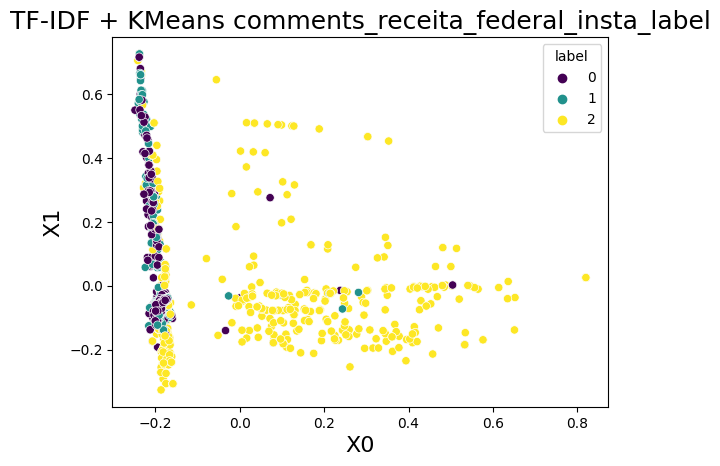

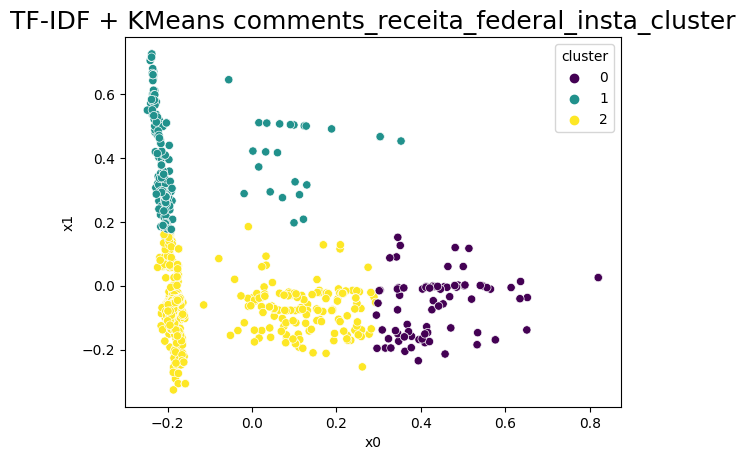

In [24]:
# A primeira figura reproduz os comentários com os labels elaborados de maneira manual. A segunda foi realizada utilizando o kmeans
# set image size
plt.figure(figsize=(15, 15))
chart1, ax1 = plt.subplots()
# set a title
plt.title("TF-IDF + KMeans comments_receita_federal_insta_label", fontdict={"fontsize": 18})
# set axes names
plt.xlabel("X0", fontdict={"fontsize": 16})
plt.ylabel("X1", fontdict={"fontsize": 16})
# create scatter plot with seaborn, where hue is the class used to group the data
sns.scatterplot(data=df, x='x0', y='x1', hue='label', palette="viridis", ax=ax1)
chart2, ax2 = plt.subplots()
plt.title("TF-IDF + KMeans comments_receita_federal_insta_cluster", fontdict={"fontsize": 18})
sns.scatterplot(data=df, x='x0', y='x1', hue='cluster', palette="viridis",  ax=ax2)
plt.show()

Realmente, como já suspeitado, o resultado obtido foi ruim. Foi realizado nova tentativa modificando o algoritmo de clusterização pelo DBSCAN.

In [25]:
from sklearn.cluster import DBSCAN

In [26]:
db = DBSCAN(eps=0.9, min_samples=10).fit(X)
labels = db.labels_

In [27]:
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Número estimado de clusters: %d" % n_clusters_)
print("Número estimado de pontos que são ruídos: %d" % n_noise_)

Número estimado de clusters: 5
Número estimado de pontos que são ruídos: 1139


In [28]:
df['cluster_db'] = labels

<Figure size 1500x1500 with 0 Axes>

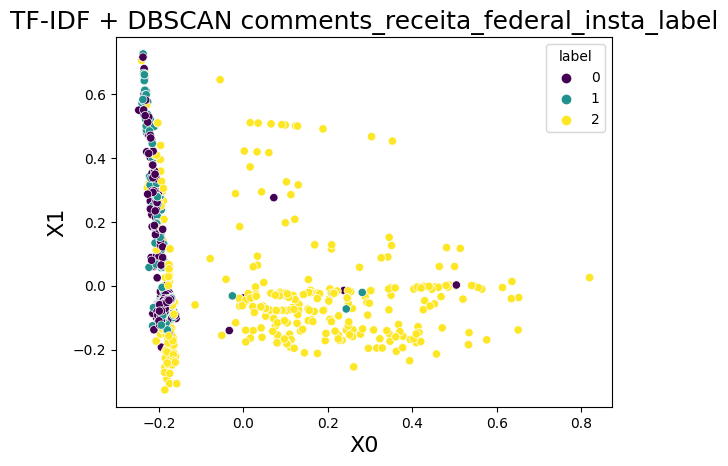

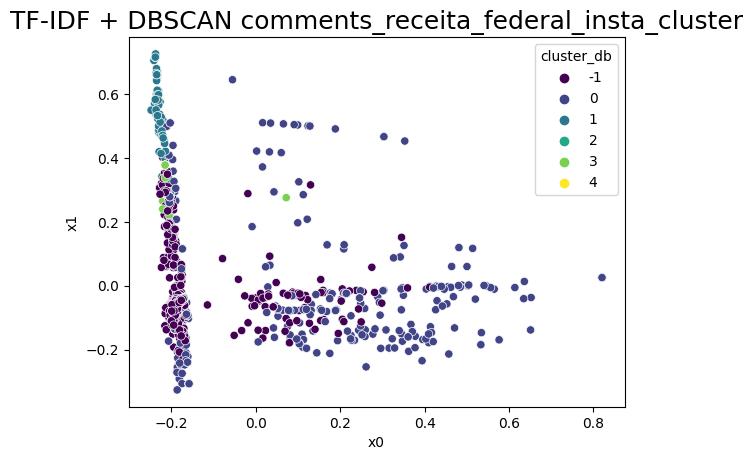

In [29]:

# set image size
plt.figure(figsize=(15, 15))
chart1, ax1 = plt.subplots()
# set a title
plt.title("TF-IDF + DBSCAN comments_receita_federal_insta_label", fontdict={"fontsize": 18})
# set axes names
plt.xlabel("X0", fontdict={"fontsize": 16})
plt.ylabel("X1", fontdict={"fontsize": 16})
# create scatter plot with seaborn, where hue is the class used to group the data
sns.scatterplot(data=df, x='x0', y='x1', hue='label', palette="viridis", ax=ax1)
chart2, ax2 = plt.subplots()
plt.title("TF-IDF + DBSCAN comments_receita_federal_insta_cluster", fontdict={"fontsize": 18})
sns.scatterplot(data=df, x='x0', y='x1', hue='cluster_db', palette="viridis",  ax=ax2)
plt.show()

Novamente o resultado obtido não foi satisfatório. Dessa forma, optou-se por utilizar apenas os dados já rotulados manualmente.

## Classificadores

### SVM + BOW (TFIDF)

In [30]:
# A base de teste foi definida em 20%
X_train, X_test, y_train, y_test = train_test_split(df.comments_without_emoji, df.label, test_size=0.2, random_state=42)

In [31]:
# Como o SVC tem como parâmetro disponível o peso das classes e como há um desbalanceamento na base isso foi explorado
label_0 = df['label'].value_counts()[0]
label_1 = df['label'].value_counts()[1]
label_2 = df['label'].value_counts()[2]

weight_0 = total_comments - label_0
weight_1 = total_comments - label_1
weight_2 = total_comments - label_2

In [32]:
text_svm = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('svm', SVC(class_weight={0: weight_0, 1: weight_1, 2: weight_2}, random_state=42)),
])

In [33]:
text_svm.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('svm',
                 SVC(class_weight={0: 1549, 1: 1263, 2: 1232},
                     random_state=42))])

In [34]:
predicted = text_svm.predict(X_test)

In [35]:
print(metrics.classification_report(y_test, predicted))
metrics.confusion_matrix(y_test, predicted)

              precision    recall  f1-score   support

           0       0.83      0.52      0.64       103
           1       0.66      0.88      0.76       147
           2       0.95      0.88      0.92       155

    accuracy                           0.79       405
   macro avg       0.82      0.76      0.77       405
weighted avg       0.82      0.79      0.79       405



array([[ 54,  49,   0],
       [ 10, 130,   7],
       [  1,  17, 137]])

In [36]:
exemplo = random.randrange(405)
print('comment: ', X_test.iloc[exemplo], '\nprevisto: ', predicted[exemplo], '\ncorreto: ', y_test.iloc[exemplo])

comment:  Eu sofri 2 de 1 "cliente" mais não soube qual providência tomar 
previsto:  1 
correto:  1


### SVM + Embeddings

In [37]:
# Para utilização dos modelos de word embeddings pré-treinados
import gensim.downloader
from gensim.models import Word2Vec

glove_vectors = gensim.downloader.load('glove-wiki-gigaword-50')

[==================================================] 100.0% 66.0/66.0MB downloaded


In [38]:
pip install --upgrade gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [39]:
# Pré-processamento textual antes de treinar o modelo Word2Vec
import nltk
from nltk.tokenize import word_tokenize
# tokenizador de sentença do nltk
nltk.download('punkt')

tokenized_sents = [word_tokenize(i) for i in df['comments_without_emoji'].values]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [40]:
model_review = Word2Vec(tokenized_sents, vector_size=100, window=5, min_count=1, workers=4)

In [41]:
model_review.wv.get_vector('Receita')

array([-0.13391808,  0.41808137, -0.06699017, -0.07521412,  0.23187459,
       -0.34221765,  0.21029316,  0.6320363 , -0.193822  , -0.24871634,
       -0.2247535 , -0.36077157, -0.02053669,  0.1341352 ,  0.20572351,
       -0.35616803,  0.09700149, -0.19584325,  0.00643389, -0.62742084,
        0.0411141 ,  0.18016759, -0.02146582, -0.09930453, -0.2527649 ,
       -0.19502848, -0.32814524, -0.07006817, -0.3862876 , -0.07659981,
        0.2940014 ,  0.1414128 , -0.06373389, -0.2727963 , -0.39108542,
        0.21935578, -0.13336395, -0.26005855, -0.29280293, -0.62552464,
        0.09135295, -0.22099093,  0.00350262,  0.07614717,  0.5418965 ,
       -0.09822922, -0.22436702, -0.13494466,  0.35856497,  0.25332054,
        0.16406268, -0.12487079,  0.01533036, -0.12312884, -0.37238938,
       -0.05830465, -0.09868998, -0.06959923, -0.24943931, -0.05810104,
        0.12371224, -0.10741325,  0.24703482,  0.18082236, -0.40990764,
        0.36944875, -0.05660801,  0.35347077, -0.6660833 ,  0.26

In [42]:
model_review.wv.get_vector('Parabéns')

array([-0.13375369,  0.30947945,  0.03232265,  0.04305359,  0.11933702,
       -0.3259772 ,  0.18676852,  0.5641004 , -0.2131506 , -0.24372764,
       -0.1043043 , -0.31054422, -0.04655225,  0.13287096,  0.1385798 ,
       -0.24165696,  0.1298748 , -0.14484373, -0.05573276, -0.5247193 ,
        0.07157329,  0.12207618,  0.08384981, -0.09770996, -0.1443048 ,
       -0.12002669, -0.26634416, -0.01683902, -0.29843923, -0.02390951,
        0.24930727,  0.07047734,  0.08296461, -0.25002882, -0.25801766,
        0.1736981 , -0.00241287, -0.1996559 , -0.18691713, -0.49571434,
        0.05409608, -0.18619262, -0.09849413,  0.04417086,  0.34708405,
       -0.06377217, -0.19443569, -0.05046823,  0.27481636,  0.22731031,
        0.11465812, -0.13205813, -0.02493893, -0.08731849, -0.23654863,
       -0.0256813 , -0.02600803, -0.04467191, -0.20576726,  0.03600363,
        0.00059627, -0.0500715 ,  0.14470886,  0.0624271 , -0.3194605 ,
        0.3323836 ,  0.01403033,  0.29063305, -0.47906074,  0.22

In [43]:
# Verificando o tamanho máximo do texto não estruturado (review)
X, y = [], []
max_len = 0

for i, row in df.iterrows():
  vetores = model_review.wv[word_tokenize(row['comments_without_emoji'])]

  max_len = max(max_len, len(vetores))
  X.append(vetores)
  y.append(row['label'])
print("max_len: {}".format(max_len))

max_len: 295


In [44]:
# Devemos utilizar um padding para padronizar o tamanho das nossas reviews em max_len.
# Isso é necessário para fazer o treino da rede neural

def transform(exemplos, dimension):
  results = np.zeros((len(exemplos), dimension, 100))
  for i, sequence in enumerate(exemplos):
    results[i, :len(sequence), :] = sequence
  return results
 
X = transform(X, max_len)
y = np.array(y).astype("float32")

In [45]:
# O array tem 3 dimensões dessa forma será aplicado um reshape para diminuir a quantidade de dimensões.
# Isso foi realizado pela limitação do modelo escolhido para trabalhar com mais de 2 dimensões.
X.shape

(2022, 295, 100)

In [46]:
nsamples, nx, ny = X.shape
X_reshape = X.reshape((nsamples,nx*ny))

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X_reshape, y, test_size=0.2, random_state=42)

In [48]:
text_svm = Pipeline([
        ('svm', SVC(class_weight={0: weight_0, 1: weight_1, 2: weight_2}, random_state=42)),
])

In [49]:
text_svm.fit(X_train, y_train)

Pipeline(steps=[('svm',
                 SVC(class_weight={0: 1549, 1: 1263, 2: 1232},
                     random_state=42))])

In [50]:
predicted = text_svm.predict(X_test)

In [51]:
print(metrics.classification_report(y_test, predicted))
metrics.confusion_matrix(y_test, predicted)

              precision    recall  f1-score   support

         0.0       0.40      0.37      0.39       103
         1.0       0.55      0.58      0.56       147
         2.0       0.79      0.80      0.80       155

    accuracy                           0.61       405
   macro avg       0.58      0.58      0.58       405
weighted avg       0.61      0.61      0.61       405



array([[ 38,  53,  12],
       [ 42,  85,  20],
       [ 14,  17, 124]])

In [52]:
confusion_matrix_ambeddings = metrics.confusion_matrix(y_test, predicted)

### BERT

In [53]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 57.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 81.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 26.2 MB/s eta 0:00:00


In [54]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np

from tabulate import tabulate
from tqdm import trange
import random

In [55]:
# Foi escolhido o tokenizer BERT multilingual que inclui o português
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-multilingual-cased',
    do_lower_case = True
    )

In [56]:
text = df.comments_without_emoji.values
labels = df.label.values

In [57]:
len(text)

2022

In [58]:
def print_rand_sentence():
  '''Displays the tokens and respective IDs of a random text sample'''
  index = random.randint(0, len(text)-1)
  table = np.array([tokenizer.tokenize(text[index]), 
                    tokenizer.convert_tokens_to_ids(tokenizer.tokenize(text[index]))]).T
  print(tabulate(table,
                 headers = ['Tokens', 'Token IDs'],
                 tablefmt = 'fancy_grid'))

print_rand_sentence()

╒═══════════════╤═════════════╕
│ Tokens        │   Token IDs │
╞═══════════════╪═════════════╡
│ fac           │      107159 │
├───────────────┼─────────────┤
│ ##am          │       11008 │
├───────────────┼─────────────┤
│ uma           │       10437 │
├───────────────┼─────────────┤
│ re            │       11639 │
├───────────────┼─────────────┤
│ ##ci          │       10598 │
├───────────────┼─────────────┤
│ ##cla         │       60582 │
├───────────────┼─────────────┤
│ ##gem         │       20531 │
├───────────────┼─────────────┤
│ com           │       10212 │
├───────────────┼─────────────┤
│ isso          │       24344 │
├───────────────┼─────────────┤
│ funcionarios  │      101921 │
├───────────────┼─────────────┤
│ de            │       10104 │
├───────────────┼─────────────┤
│ voces         │       64149 │
├───────────────┼─────────────┤
│ ,             │         117 │
├───────────────┼─────────────┤
│ eles          │       19695 │
├───────────────┼─────────────┤
│ na    

In [59]:
token_id = []
attention_masks = []

def preprocessing(input_text, tokenizer):
  '''
  Returns <class transformers.tokenization_utils_base.BatchEncoding> with the following fields:
    - input_ids: list of token ids
    - token_type_ids: list of token type ids
    - attention_mask: list of indices (0,1) specifying which tokens should considered by the model (return_attention_mask = True).
  '''
  return tokenizer.encode_plus(
                        input_text,
                        add_special_tokens = True,
                        max_length = 100,
                        padding = "max_length",
                        return_attention_mask = True,
                        return_tensors = 'pt',
                        truncation=True
                   )


for sample in text:
  encoding_dict = preprocessing(sample, tokenizer)
  token_id.append(encoding_dict['input_ids']) 
  attention_masks.append(encoding_dict['attention_mask'])


token_id = torch.cat(token_id, dim = 0)
attention_masks = torch.cat(attention_masks, dim = 0)
labels = torch.tensor(labels)

In [60]:
def print_rand_sentence_encoding():
  '''Displays tokens, token IDs and attention mask of a random text sample'''
  index = random.randint(0, len(text) - 1)
  tokens = tokenizer.tokenize(tokenizer.decode(token_id[index]))
  token_ids = [i.numpy() for i in token_id[index]]
  attention = [i.numpy() for i in attention_masks[index]]

  table = np.array([tokens, token_ids, attention]).T
  print(tabulate(table, 
                 headers = ['Tokens', 'Token IDs', 'Attention Mask'],
                 tablefmt = 'fancy_grid'))

print_rand_sentence_encoding()

╒══════════╤═════════════╤══════════════════╕
│ Tokens   │   Token IDs │   Attention Mask │
╞══════════╪═════════════╪══════════════════╡
│ [CLS]    │         101 │                1 │
├──────────┼─────────────┼──────────────────┤
│ :        │         131 │                1 │
├──────────┼─────────────┼──────────────────┤
│ mao      │       16749 │                1 │
├──────────┼─────────────┼──────────────────┤
│ ##s      │       10107 │                1 │
├──────────┼─────────────┼──────────────────┤
│ _        │         168 │                1 │
├──────────┼─────────────┼──────────────────┤
│ ap       │       26219 │                1 │
├──────────┼─────────────┼──────────────────┤
│ ##lau    │       35166 │                1 │
├──────────┼─────────────┼──────────────────┤
│ ##din    │       15612 │                1 │
├──────────┼─────────────┼──────────────────┤
│ ##do     │       10317 │                1 │
├──────────┼─────────────┼──────────────────┤
│ :        │         131 │        

In [61]:
val_ratio = 0.2
batch_size = 16

# Indices of the train and validation splits stratified by labels
train_idx, val_idx = train_test_split(
    np.arange(len(labels)),
    test_size = val_ratio,
    shuffle = True,
    stratify = labels)

# Train and validation sets
train_set = TensorDataset(token_id[train_idx], 
                          attention_masks[train_idx], 
                          labels[train_idx])

val_set = TensorDataset(token_id[val_idx], 
                        attention_masks[val_idx], 
                        labels[val_idx])

# Prepare DataLoader
train_dataloader = DataLoader(
            train_set,
            sampler = RandomSampler(train_set),
            batch_size = batch_size
        )

validation_dataloader = DataLoader(
            val_set,
            sampler = SequentialSampler(val_set),
            batch_size = batch_size
        )

In [62]:
def b_tp(preds, labels):
  '''Returns True Positives (TP): count of correct predictions of actual class 1'''
  return sum([preds == labels and preds == 1 for preds, labels in zip(preds, labels)])

def b_fp(preds, labels):
  '''Returns False Positives (FP): count of wrong predictions of actual class 1'''
  return sum([preds != labels and preds == 1 for preds, labels in zip(preds, labels)])

def b_tn(preds, labels):
  '''Returns True Negatives (TN): count of correct predictions of actual class 0'''
  return sum([preds == labels and preds == 0 for preds, labels in zip(preds, labels)])

def b_fn(preds, labels):
  '''Returns False Negatives (FN): count of wrong predictions of actual class 0'''
  return sum([preds != labels and preds == 0 for preds, labels in zip(preds, labels)])

def b_metrics(preds, labels):
  '''
  Returns the following metrics:
    - accuracy    = (TP + TN) / N
    - precision   = TP / (TP + FP)
    - recall      = TP / (TP + FN)
    - specificity = TN / (TN + FP)
  '''
  preds = np.argmax(preds, axis = 1).flatten()
  labels = labels.flatten()
  tp = b_tp(preds, labels)
  tn = b_tn(preds, labels)
  fp = b_fp(preds, labels)
  fn = b_fn(preds, labels)
  b_accuracy = (tp + tn) / len(labels)
  b_precision = tp / (tp + fp) if (tp + fp) > 0 else 'nan'
  b_recall = tp / (tp + fn) if (tp + fn) > 0 else 'nan'
  b_specificity = tn / (tn + fp) if (tn + fp) > 0 else 'nan'
  return b_accuracy, b_precision, b_recall, b_specificity

In [63]:
# Load the BertForSequenceClassification model
model = BertForSequenceClassification.from_pretrained(
    'bert-base-multilingual-cased',
    num_labels = 3,
    output_attentions = False,
    output_hidden_states = False,
)

optimizer = torch.optim.AdamW(model.parameters(), 
                              lr = 5e-5,
                              eps = 1e-08
                              )

model.cuda()

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [64]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

epochs = 4

for _ in trange(epochs, desc = 'Epoch'):
    
    # ========== Training ==========
    
    # Set model to training mode
    model.train()
    
    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        optimizer.zero_grad()
        # Forward pass
        train_output = model(b_input_ids, 
                             token_type_ids = None, 
                             attention_mask = b_input_mask, 
                             labels = b_labels)
        # Backward pass
        train_output.loss.backward()
        optimizer.step()
        # Update tracking variables
        tr_loss += train_output.loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    # ========== Validation ==========

    # Set model to evaluation mode
    model.eval()

    # Tracking variables 
    val_accuracy = []
    val_precision = []
    val_recall = []
    val_specificity = []

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
          # Forward pass
          eval_output = model(b_input_ids, 
                              token_type_ids = None, 
                              attention_mask = b_input_mask)
        logits = eval_output.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        # Calculate validation metrics
        b_accuracy, b_precision, b_recall, b_specificity = b_metrics(logits, label_ids)
        val_accuracy.append(b_accuracy)
        # Update precision only when (tp + fp) !=0; ignore nan
        if b_precision != 'nan': val_precision.append(b_precision)
        # Update recall only when (tp + fn) !=0; ignore nan
        if b_recall != 'nan': val_recall.append(b_recall)
        # Update specificity only when (tn + fp) !=0; ignore nan
        if b_specificity != 'nan': val_specificity.append(b_specificity)

    print('\n\t - Train loss: {:.4f}'.format(tr_loss / nb_tr_steps))
    print('\t - Validation Accuracy: {:.4f}'.format(sum(val_accuracy)/len(val_accuracy)))
    print('\t - Validation Precision: {:.4f}'.format(sum(val_precision)/len(val_precision)) if len(val_precision)>0 else '\t - Validation Precision: NaN')
    print('\t - Validation Recall: {:.4f}'.format(sum(val_recall)/len(val_recall)) if len(val_recall)>0 else '\t - Validation Recall: NaN')
    print('\t - Validation Specificity: {:.4f}\n'.format(sum(val_specificity)/len(val_specificity)) if len(val_specificity)>0 else '\t - Validation Specificity: NaN')

Epoch:  25%|██▌       | 1/4 [00:32<01:36, 32.02s/it]


	 - Train loss: 0.6765
	 - Validation Accuracy: 0.4106
	 - Validation Precision: 0.6592
	 - Validation Recall: 0.9194
	 - Validation Specificity: 0.3701



Epoch:  50%|█████     | 2/4 [01:03<01:02, 31.47s/it]


	 - Train loss: 0.5021
	 - Validation Accuracy: 0.4736
	 - Validation Precision: 0.7779
	 - Validation Recall: 0.7532
	 - Validation Specificity: 0.6810



Epoch:  75%|███████▌  | 3/4 [01:34<00:31, 31.61s/it]


	 - Train loss: 0.3378
	 - Validation Accuracy: 0.4183
	 - Validation Precision: 0.8692
	 - Validation Recall: 0.5322
	 - Validation Specificity: 0.8673



Epoch: 100%|██████████| 4/4 [02:07<00:00, 31.78s/it]


	 - Train loss: 0.2410
	 - Validation Accuracy: 0.4563
	 - Validation Precision: 0.7312
	 - Validation Recall: 0.8344
	 - Validation Specificity: 0.5832



In [66]:
new_sentence = 'Tá deixando a desejar'

# We need Token IDs and Attention Mask for inference on the new sentence
test_ids = []
test_attention_mask = []

# Apply the tokenizer
encoding = preprocessing(new_sentence, tokenizer)

# Extract IDs and Attention Mask
test_ids.append(encoding['input_ids'])
test_attention_mask.append(encoding['attention_mask'])
test_ids = torch.cat(test_ids, dim = 0)
test_attention_mask = torch.cat(test_attention_mask, dim = 0)

# Forward pass, calculate logit predictions
with torch.no_grad():
  output = model(test_ids.to(device), token_type_ids = None, attention_mask = test_attention_mask.to(device))

prediction = np.argmax(output.logits.cpu().numpy()).flatten().item()

print('Input Sentence: ', new_sentence)
print('Predicted Class: ', prediction)

Input Sentence:  Tá deixando a desejar
Predicted Class:  0


## Conclusão

Aparentemente pelas métricas utilizadas o modelo que obteve o melhor desempenho foi o SVM + BOW (TFIDF). Um dos motivos para isso ocorrer pode ser o domínio da base que é bem específico, além da utilização massiva de recursos como emoji que trazem uma outra dinâmica ao texto. Outro fator que pode ter influenciado é o número de samples disponíveis. Modelos de deep learning como o BERT necessitam de uma grande quantidade de dados para obter um resultado satisfatório.

Dessa forma, o resultado obtido demonstra a necessidade de dominar bem as técnicas que podem ser utilizadas na parte de processamento de linguagem natural. Afinal, em alguns casos, a depender do problema, um modelo mais simples pode resolver o problema de maneira satisfatória e sem demandar muitos recursos computacionais.